### <font color = 'green'> 1. Загрузка библиотек</font>

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import pingouin as pg
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline

### <font color = 'green'> 2. Загрузка данных </font>

In [2]:
AA_test = pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv', sep = ';', index_col=0)

In [3]:
AA_test.head()

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


### <font color = 'green'>  3. Простое исследование: наличие NULL, тип данных, определение категориальных переменных </font>

In [4]:
AA_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127018 entries, 1 to 127018
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   uid                127018 non-null  object
 1   experimentVariant  127018 non-null  int64 
 2   version            127018 non-null  object
 3   purchase           127018 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 4.8+ MB


In [5]:
AA_test.nunique()

uid                  127018
experimentVariant         2
version                   4
purchase                  2
dtype: int64

**experimentVariant - категориальная переменная с 2-мя градациями**
- 0 - группа 0
- 1 - группа 1

In [6]:
AA_test.experimentVariant.unique()

array([1, 0], dtype=int64)

**version - категориальная переменная с 4-мя градациями версий обновления мобильного приложения**
- v2.8.0 
- v2.9.0
- v3.7.4.0
- v3.8.0.0

In [7]:
AA_test.version.unique()

array(['v2.8.0', 'v2.9.0', 'v3.7.4.0', 'v3.8.0.0'], dtype=object)

**purchase - категориальная переменная с 2-мя градациями информации о покупке**
- 0 - состояние покупки 0
- 1 - состояние покупки 1

In [8]:
AA_test.purchase.unique()

array([0, 1], dtype=int64)

### <font color = 'green'> 4. A/A test</font>
- a = 0.05
- размер выборки в каждой симуляции 1000

Результат: гистограмма А/А test явно имеет не равномерное распределение. Метрика качества `FPR > 0.05`.<br>
**Вывод:** возникает явная аномалия при разделении данных на группы

  0%|          | 0/1000 [00:00<?, ?it/s]

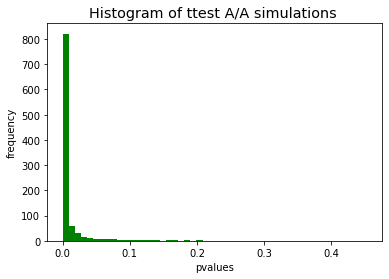

0.941

In [9]:
simulations = 1000 # кол-во выборок
n_s = 1000 #размер выборки
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = AA_test.query('experimentVariant == 0').purchase.sample(n_s, replace = False).values
    s2 = AA_test.query('experimentVariant == 1').purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50, color = 'green')
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

### <font color = 'green'> 5. Поиск причин аномалии в системе разделения данных на группы</font>

**Расчет конверсии** 

 - *Вывод*: есть выраженное различие в конверсии мобильного приложения версии v2.8.0 в эксперементальной группе 0 и 1

In [10]:
AA_test.groupby(['experimentVariant', 'version']).purchase.mean().mul(100)

experimentVariant  version 
0                  v2.8.0      0.099314
                   v2.9.0      7.465817
                   v3.7.4.0    5.994291
                   v3.8.0.0    5.760450
1                  v2.8.0      4.560551
                   v2.9.0      7.130391
                   v3.7.4.0    6.301824
                   v3.8.0.0    6.284779
Name: purchase, dtype: float64

Посчитайте pvalue для каждой версии МП

**Сравнение эксперементальных групп в срезе мобильного приложения**<br>
*убедиться, что значения в разной конверсии по одной и тойже версии приложения, статистически значимы*

- Для проверки используется U-test (ниже под каждой рассчитанной парой, приведен расчет t-test, но его применять не стоит, так как тест на нормальность дает статистически значимое отклоление)

 - *Вывод*: есть выраженное различие в конверсии мобильного приложения версии v2.8.0 в эксперементальной группе 0 и 1

In [11]:
# Версия приложения v2.8.0

pg.mwu(x = AA_test.query('experimentVariant == 0 & version == "v2.8.0"').purchase,  y = AA_test.query('experimentVariant == 1 & version == "v2.8.0"').purchase)

#различие между граппами статистически значимо, отклоняем Н0 о равенстве групп

,U-val,alternative,p-val,RBC,CLES
MWU,819431781.5,two-sided,0.0,0.044612,0.477694


In [12]:
pg.ttest(x = AA_test.query('experimentVariant == 0 & version == "v2.8.0"').purchase,  y = AA_test.query('experimentVariant == 1 & version == "v2.8.0"').purchase)

C:\Users\nihki\anaconda3\lib\site-packages\pingouin\bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-43.097052,43456.485244,two-sided,0.0,"[-0.05, -0.04]",0.298556,inf,1.0


In [ ]:
# Версия приложения v2.9.0
pg.mwu(x = AA_test.query('experimentVariant == 0 & version == "v2.9.0"').purchase,  y = AA_test.query('experimentVariant == 1 & version == "v2.9.0"').purchase)

#различие между граппами статистически не значимое, Н0 о равенстве групп не отклоняем

,U-val,alternative,p-val,RBC,CLES
MWU,71963272.5,two-sided,0.3183,-0.003354,0.501677


In [14]:
pg.ttest(x = AA_test.query('experimentVariant == 0 & version == "v2.9.0"').purchase,  y = AA_test.query('experimentVariant == 1 & version == "v2.9.0"').purchase)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.997861,23929.707513,two-sided,0.318357,"[-0.0, 0.01]",0.012896,0.024,0.169562


In [ ]:
# Версия приложения v3.7.4.0

pg.mwu(x = AA_test.query('experimentVariant == 0 & version == "v3.7.4.0"').purchase,  y = AA_test.query('experimentVariant == 1 & version == "v3.7.4.0"').purchase)

#различие между граппами статистически не значимое, Н0 о равенстве групп не отклоняем

,U-val,alternative,p-val,RBC,CLES
MWU,8845256.0,two-sided,0.556865,0.003075,0.498462


In [ ]:
pg.ttest(x = AA_test.query('experimentVariant == 0 & version == "v3.7.4.0"').purchase,  y = AA_test.query('experimentVariant == 1 & version == "v3.7.4.0"').purchase)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.58752,8419.851448,two-sided,0.55687,"[-0.01, 0.01]",0.012801,0.029,0.090375


In [ ]:
# Версия приложения v3.8.0.0

pg.mwu(x = AA_test.query('experimentVariant == 0 & version == "v3.8.0.0"').purchase,  y = AA_test.query('experimentVariant == 1 & version == "v3.8.0.0"').purchase)

#различие между граппами статистически не значимое, Н0 о равенстве групп не отклоняем

,U-val,alternative,p-val,RBC,CLES
MWU,17303962.0,two-sided,0.231856,0.005243,0.497378


In [ ]:
pg.ttest(x = AA_test.query('experimentVariant == 0 & version == "v3.8.0.0"').purchase,  y = AA_test.query('experimentVariant == 1 & version == "v3.8.0.0"').purchase)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.197337,11791.555477,two-sided,0.231199,"[-0.01, 0.0]",0.022023,0.043,0.223103


### <font color = 'green'> 6. A/A test исключение мобильного приложения v2.8.0</font>
- a = 0.05
- размер выборки в каждой симуляции 1000

Результат: гистограмма А/А test стремится к виду равномерного распределение. Метрика качества `FPR < 0.05`.<br>
**Вывод:** аномалия в разделении групп, связана с рандомизацией в версии мобильного приложения **v2.8.0**

  0%|          | 0/1000 [00:00<?, ?it/s]

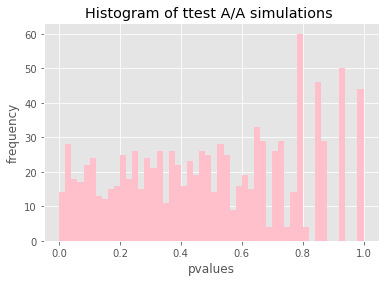

0.054

In [19]:
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = AA_test.query('experimentVariant == 0 & version != "v2.8.0"').purchase.sample(n_s, replace = False).values
    s2 = AA_test.query('experimentVariant == 1 & version != "v2.8.0"').purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50, color = 'pink')
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

В качестве бонуса, ниже показано альтернативное решение задачи

In [6]:

from statsmodels.stats.proportion import proportions_ztest
df = pd.read_csv('hw_aa.csv', sep=';',index_col=0, decimal=',')
df.head()

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [9]:

# основная функция для расчета АА с синтетическими тестами
def metric_fpr(df_x, df_y, metric_col, n_sim, n_s_perc, n_s_min, estimator, *args, **kwargs):
    stat_res = {
        'aa' : {
            'pvalue': [], 
            'mu_x': [], 
            'mu_y': []
        },
        'fpr': {
            'fpr_95': 0
        }
    }
    
    for sim in range(n_sim):
        
        # по-умолчанию берем %(n_s_perc) наблюдений от исходной, но не более n_s_min
        x = df_x[metric_col].sample(int(min(n_s_min, len(df_x) * n_s_perc)), replace = False).values 
        y = df_y[metric_col].sample(int(min(n_s_min, len(df_y) * n_s_perc)), replace = False).values

        if estimator == 'prop':
            counts = np.array([sum(x),sum(y)])
            nobs = np.array([len(x),len(y)])
            stat, pvalue = proportions_ztest(counts, nobs, *args, **kwargs)
        
        if estimator == 'ttest':
            stat, pvalue = stats.ttest_ind(x, y, *args, **kwargs)
            
        stat_res['aa']['pvalue'].append(pvalue)
        stat_res['aa']['mu_x'].append(np.mean(x))
        stat_res['aa']['mu_y'].append(np.mean(y))
        
    
    stat_res['fpr']['fpr_95'] =  float(sum(np.array(stat_res['aa']['pvalue']) <= 0.05) / n_sim)
    
    return stat_res

# считаем АА по градациям внутри измерений (группировок)
def fpr_report(df, metric_col, variant_col, group_col, n_sim, n_s_perc, n_s_min, estimator, *args, **kwargs):
    list_fpr = []
    list_group = list(pd.unique(df[group_col]))
    
    for v in range(len(list_group)):
        df_x = df[(df[variant_col] == 0) & (df[group_col] == list_group[v])]
        df_y = df[(df[variant_col] == 1) & (df[group_col] == list_group[v])]
        
        if (len(df_x) == 0) | (len(df_y) == 0):
            continue
        else:
            cr_x = sum(df_x[metric]) / len(df_x)
            cr_y = sum(df_y[metric]) / len(df_y)

            fpr = {}
            fpr = metric_fpr(
                df_x = df_x, 
                df_y = df_y, 
                metric_col = metric, 
                n_sim = n_sim,
                n_s_perc = n_s_perc,
                n_s_min = n_s_min,
                estimator = estimator, *args, **kwargs
            )
            is_fpr = (fpr['fpr']['fpr_95']<=0.05)
            list_fpr.append([list_group[v],cr_x,cr_y,fpr['fpr']['fpr_95'],is_fpr])

    report = pd.DataFrame.from_records(list_fpr, columns=['group','cr_x','cr_y','fpr_95','is_fpr'])
    
    return report

# параметры
n_sim = 500 # количество симуляций
n_s_perc = 0.9 # % наблюдений в подвыборках
n_s_min = 1000 # но не более константы
metric = 'purchase'
variant = 'experimentVariant'
group = 'version'

res = fpr_report(
    df = df,
    metric_col = metric,
    variant_col = variant,
    group_col = group,
    n_sim = n_sim,
    n_s_perc = n_s_perc,
    n_s_min = n_s_min,
    estimator = 'prop'
)

res

/Users/iskander/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/weightstats.py:671: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std_diff
/Users/iskander/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less_equal


,group,cr_x,cr_y,fpr_95,is_fpr
0,3.8.2.0,0.066557,0.067081,0.044,True
1,2.8.0,0.000000,0.045606,1.000,False
2,2.9.0,0.074658,0.071304,0.044,True
3,3.7.4.0,0.059943,0.063018,0.038,True
4,3.8.0.0,0.057604,0.062848,0.046,True
5,3.8.3.0,0.060475,0.052519,0.000,True
6,3.8.1.0,0.000000,0.000000,0.000,True
7,3.7.2.0,0.000000,0.000000,0.000,True


Видим, что проблемы в 2.8.0 версии. По сути мы могли бы итерироваться по другим измерениям и в конце концов нашли бы причину на самом низком уровне

In [8]:
np.random.seed(1)
group = 'operatingSystem'
df_fltrd = df[(df['version']!='2.8.0')]

res = fpr_report(
    df = df_fltrd,
    metric_col = metric,
    variant_col = variant,
    group_col = group,
    n_sim = n_sim,
    n_s_perc = n_s_perc,
    n_s_min = n_s_min,
    estimator = 'prop'
)

res


,group,cr_x,cr_y,fpr_95,is_fpr
0,ANDROID,0.065903,0.066633,0.038,True
1,IOS,0.074658,0.071292,0.044,True
